# Generating Features

In [2]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output, display
from sklearn import preprocessing
import copy
from matplotlib.pyplot import figure
from scipy.fft import fft
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tqdm
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

## Setting window size

In [237]:
# fs deducted by previous inspection of the eeg files
fs = 2500.0
# time is in seconds (last value tried is 100, but you should change it to anything between 0.5 and 10)
time = 100
window_size = int(time*fs)
print("Window_size = " + str(window_size))

Window_size = 250000


# Signal Ops class has all the functions needed to generate features on the frequency domain of the signal (mainly PSD)

In [238]:
class SignalOps:
    @staticmethod
    def PSD(y,fs,interval='auto',plot=False):
        if interval == 'auto':
            y_copy = copy.copy(y)
        else:
            y_copy = copy.copy(y)[int(interval[0]*fs):int(interval[1]*fs)]
            
        f, Pxx_den = signal.welch(y_copy.flatten(), fs, nperseg=512)
        if plot:
            plt.semilogy(f, Pxx_den)
            plt.xlabel('frequency [Hz]')
            plt.ylabel('PSD')
            plt.show()
        max_y = np.max(Pxx_den)  # Find the maximum y value
        max_x = f[Pxx_den.argmax()]  # Find the x value corresponding to the maximum y value
        avgPSD = np.mean(Pxx_den)
        if plot:
            print("Max at " + str(int(max_x)) + " Hz")
        return max_y, avgPSD
    @staticmethod
    def PSD_features(y,fs):
        f, Pxx_den = signal.welch(y.flatten(), fs, nperseg=len(y))
        index6Hz = np.where(f==6)[0][0]
        index8Hz = np.where(f==8)[0][0]
        index10Hz = np.where(f==10)[0][0]
        index12Hz = np.where(f==12)[0][0]
        index50Hz = np.where(f==50)[0][0]
        index52Hz = np.where(f==52)[0][0]
        index54Hz = np.where(f==54)[0][0]
        index56Hz = np.where(f==56)[0][0]
        psds = [Pxx_den[index6Hz],Pxx_den[index8Hz],Pxx_den[index10Hz],Pxx_den[index12Hz],Pxx_den[index50Hz],Pxx_den[index52Hz],Pxx_den[index54Hz],Pxx_den[index56Hz]]
        return psds
    @staticmethod
    def plot_fft(x,y,fs):
        N = len(x)
        T = 1.0 / fs
        yf = fft(y)
        xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
        plt.grid()
        plt.show()

# Label file class deals with with creating the labels (hardcoded based on signal inspection), generating the features and plotting signal information

In [239]:
# Labeling for MaRri001
class LabelFile:
    def __init__(self,window_size,channels):
        # use marri001 or marri007
        marri007 = "../data/t_elec_15/MarRi_2_0007.vhdr"
        marri001 = "../data/t_elec_13/MarRi0001.vhdr"
        self.raw = mne.io.read_raw_brainvision(marri001,preload=True,verbose=False)
        self.data = self.raw.filter(l_freq=8,h_freq=12,method="iir")
        
        # index 6 is for refFp1
        self.channels = channels
        self.raw_selection = self.data[0,:]
        self.x = self.raw_selection[1]
        self.y = self.raw_selection[0].T
        self.fs = self.raw.info['sfreq']
        self.nperseg = 512
        self.labels = copy.copy(self.x)
        self.window_size = window_size
        
        #Hard coded labeling for Marri001
        
        for i in range(0,len(self.x)):
            if self.x[i] < 48:
                self.labels[i] = 1;
            elif self.x[i] > 55 and self.x[i] < 115:
                self.labels[i] = 1;
            else:
                self.labels[i] = 0;


         # Hard coded labeling for Marri007
        
#         for i in range(0,len(self.x)):
#             if self.x[i] < 30:
#                 self.labels[i] = 1;
#             elif self.x[i] >= 30 and self.x[i] < 58:
#                 self.labels[i] = 0;
#             else:
#                 self.labels[i] = 1;

        self.labels = self.labels.astype(int)
        dists = np.bincount(self.labels.flatten())
        print("Number of 0s: " + str(dists[0]))
        print("Number of 1s: " + str(dists[1]))

        
    def plot_info(self):
        #Plotting info of the signal
        print("CzOz Signal and Label ")
        fig, ax1 = plt.subplots()

        color = 'tab:blue'
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('amplitude', color=color)
        ax1.plot(self.x, self.y, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  

        color = 'tab:red'
        ax2.set_ylabel('label', color=color)
        ax2.plot(self.x, self.labels, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  
        plt.show()
        print("FFT")
        SignalOps.plot_fft(self.x,self.y,fs)
        print("PSD")
        SignalOps.PSD(self.y,fs)


    def generateDataset_time_features(self):
        # For each channel (except CzOz), generate the features and save them in a dataframe
        # CzOz is not saved for speedup reasons since we're not interested in this channel
        current_window_size = self.window_size
        dict = {}
        step = 1
        for index, channel in enumerate(self.channels):
            print(channel)
            if channel == "CzOz":
                continue
            else:
                # use marri001 or marri007
                marri007 = "../data/t_elec_15/MarRi_2_0007.vhdr"
                marri001 = "../data/t_elec_13/MarRi0001.vhdr"
                self.raw = mne.io.read_raw_brainvision(marri001,preload=True,verbose=False)
                self.data = self.raw.filter(l_freq=8,h_freq=12,method="iir")
                self.raw_selection = self.data[index,:]
                self.x = self.raw_selection[1]
                self.y = self.raw_selection[0].T
                
                stds = []
                varis = []
                means = []
                meds = []
                maxs = []
                mins = []
                rms = []
                ampli = []
                peakPSD = []
                avgPSD = []
                
                lbls = []
                xs = []
                ys = []
                # step is the increment step between two consecutive frames 
                # by default it should be 1 to get number of generated frames = number of signal samples 
                step = 20
                for i in range(0,len(self.x),step):
                    if (i+current_window_size) > len(self.x):
                        current_window_size = len(self.x) - i
                        step = len(self.x) - i
                    current_window = self.y[i:current_window_size+i]
                    
                    # Generating Features
                    
                    stds.append(np.std(current_window))
                    varis.append(np.var(current_window))
                    means.append(np.mean(current_window))
                    meds.append(np.median(current_window))
                    maxs.append(np.max(current_window))
                    mins.append(np.min(current_window))
                    rms.append(np.sqrt(np.mean(np.square(current_window))))
                    ampli.append(np.max(current_window)-np.min(current_window))
                    peakPSD_tmp, avgPSD_tmp = SignalOps.PSD(current_window,self.fs)
                    peakPSD.append(peakPSD_tmp)
                    avgPSD.append(avgPSD_tmp)
                    
                    # Keeping track of labels
                    
                    lbl = self.labels[i]
                    lbls.append(lbl)
                    xs.append(self.x[i])
                    ys.append(self.y[i][0])
                    
                dict ['X'+str(index)] = xs
                dict ['Y'+str(index)] = ys
                dict ['stds'+str(index)] = stds
                dict ['varis'+str(index)] = varis
                dict ['means'+str(index)] = means
                dict ['meds'+str(index)] = meds
                dict ['maxs'+str(index)] = maxs
                dict ['mins'+str(index)] = mins
                dict ['rms'+str(index)] = rms
                dict ['ampli'+str(index)] = ampli
                dict ['peakPSD'+str(index)] = peakPSD
                dict ['avgPSD'+str(index)] = avgPSD
                dict ['Label'] = lbls
                
        
        df_dataset = pd.DataFrame(dict)
        return df_dataset
            
        
    def dataset_balance(self, df_dataset,normalize=False):
        # Balance the dataset, we assume that the number of 1's in more than the number of zeros.
        zeros_df = df_dataset[df_dataset["Label"] == 0] 
        ones_df = df_dataset[df_dataset["Label"] == 1]
        ones_df = ones_df.sample(len(zeros_df))
        frames = [zeros_df,ones_df]
        new_dataset = pd.concat(frames)
        
        
        new_dataset = new_dataset.sort_values(by=['X1'], ascending=True)
        signal_df = new_dataset
        new_dataset = new_dataset[["stds1","varis1","means1","meds1","maxs1","mins1","stds2","varis2","means2","meds2","maxs2","mins2","stds3","varis3","means3","meds3","maxs3","mins3","stds4","varis4","means4","meds4","maxs4","mins4","stds5","varis5","means5","meds5","maxs5","mins5","stds6","varis6","means6","meds6","maxs6","mins6","stds7","varis7","means7","meds7","maxs7","mins7","Label"]]
        
        if normalize == True:
            print("Normalized")
            labls = new_dataset["Label"].values
            x = new_dataset[["stds1","varis1","means1","meds1","maxs1","mins1","stds2","varis2","means2","meds2","maxs2","mins2","stds3","varis3","means3","meds3","maxs3","mins3","stds4","varis4","means4","meds4","maxs4","mins4","stds5","varis5","means5","meds5","maxs5","mins5","stds6","varis6","means6","meds6","maxs6","mins6","stds7","varis7","means7","meds7","maxs7","mins7"]].values
            scaler = StandardScaler()
            x_scaled = scaler.fit_transform(x)
            df_dataset=pd.DataFrame(x_scaled, columns=new_dataset[["stds1","varis1","means1","meds1","maxs1","mins1","stds2","varis2","means2","meds2","maxs2","mins2","stds3","varis3","means3","meds3","maxs3","mins3","stds4","varis4","means4","meds4","maxs4","mins4","stds5","varis5","means5","meds5","maxs5","mins5","stds6","varis6","means6","meds6","maxs6","mins6","stds7","varis7","means7","meds7","maxs7","mins7"]].columns)
            df_dataset["Label"] = labls
            return df_dataset,signal_df,scaler
        return new_dataset,signal_df
    
    
    def dataset_normalize(self, df_dataset, type="minmax"):
        # Normalize dataset
        if type=="minmax":
            minmaxScaler = MinMaxScaler(feature_range=[-1,1])
            data_scaled = minmaxScaler.fit_transform(df_dataset.values)
        elif type=="standard":
            standScaler = StandardScaler()
            data_scaled = standScaler.fit_transform(df_dataset.values)
        
        df_dataset_scaled = pd.DataFrame(data_scaled, columns=df_dataset.columns)
        return df_dataset_scaled
    
    def extract_channel_features(self, df_dataset, channel='all'): 
        # Extract selected features in channel
        df_dataset_out = pd.DataFrame()
        if channel=='all':
            return df_dataset.copy()
        else:
            for ch in channel:
                features_to_copy = [name + f"_{ch}" for name in self.feature_names[2:len(self.feature_names)-1]]
                df_dataset_out = pd.concat([df_dataset_out, df_dataset[features_to_copy]], axis=1)
            df_dataset_out = pd.concat([df_dataset_out, df_dataset['Label']], axis=1)
            return df_dataset_out
    
    def drop_features(self, df_dataset, channel, to_drop):
        features_to_drop = [feat + f"_{channel}" for feat in to_drop]
        return df_dataset.drop(columns=features_to_drop)
        
    def extract_interval(self, df_dataset, interval):
        # Extract selected interval from the dataset
        # N.B: HERE WE ASSUME THAT THE STEP_SIZE = 1.
        start = int(interval[0]*self.fs)
        end = int(interval[1]*self.fs)
        return df_dataset.loc[start:end]
        
    def plot_validation(self,preds):
        fig, ax1 = plt.subplots()

        color = 'tab:blue'
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('amplitude', color=color)
        ax1.plot(self.x, self.y, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  

        color = 'tab:red'
        ax2.set_ylabel('label', color=color)
        ax2.plot(self.x, self.labels, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        
        ax3 = ax2.twinx()  

        color = 'tab:green'
        ax3.set_ylabel('label', color=color)
        ax3.plot(self.x, preds, color=color)
        ax3.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  
        plt.show()

# Trainer class just deals with training, you may also check other notebooks for training and testing 

In [240]:
class Trainer:
    def __init__(self,trainerName,df_dataset):
        self.features = df_dataset.loc[:, df_dataset.columns != 'Label'].values
        self.labels = df_dataset["Label"].values
        print(self.features.shape)
        print(self.labels.shape)
        if(trainerName == "RF"):
            print("Random Forest")
            self.classifier = RandomForestClassifier(n_estimators=100)
        elif(trainerName =="LR"):
            print("Logistic Regression")
            self.classifier = LogisticRegression()
    
    def train_test_split(self,test_size):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.labels, test_size=test_size, random_state=8,shuffle=False)
        print("Split Done")
    def fit(self):
        self.classifier.fit(self.X_train,self.y_train)
    def score(self,X,y):
        print(self.classifier.score(X,y))
        return self.classifier.score(X,y)
    def predict(self,X):
        return self.classifier.predict(X)
    def filter_preds(self,preds,ws):
        for i in range(0,len(preds)) :
            if (i+ws) > len(preds):
                ws = len(preds) - i
            window = preds[i:i+ws]
            if np.mean(window) < 0.5:
                preds[i] = 0
            else:
                preds[i] = 1
        return preds
    def plot_confusion_matrix(self,labels,preds):
        cm = metrics.confusion_matrix(labels, preds)
        plt.figure(figsize=(6,6))
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.title('Confusion matrix', size = 15)
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ["0", "1"], rotation=0, size = 10)
        plt.yticks(tick_marks, ["0", "1"], size = 10)
        plt.tight_layout()
        plt.ylabel('Actual label', size = 15)
        plt.xlabel('Predicted label', size = 15)
        width, height = cm.shape 
        for x in range(width):
            for y in range(height):
                plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',verticalalignment='center')
    def plot_signal_prediction(self,signal_df,scaler):
        signal_x = signal_df["X"].values
        signal_y = signal_df["Y"].values
        signal_labels = signal_df["Label"].values
        signal_df = signal_df[["stds","varis","means","meds","maxs","mins","feat_6","feat_8","feat_10","feat_12","feat_50","feat_52","feat_54","feat_56"]]
        signal_features = signal_df.loc[:, signal_df.columns != 'Label'].values
        
        x_scaled = scaler.transform(signal_df)
        signal_features=pd.DataFrame(x_scaled)
        
        
        preds = self.classifier.predict(signal_features)
        preds = self.filter_preds(preds,window_size)
        
        fig, ax1 = plt.subplots()

        color = 'tab:blue'
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('amplitude', color=color)
        ax1.plot(signal_x, signal_y, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  

        color = 'tab:red'
        ax2.set_ylabel('label', color=color)
        ax2.plot(signal_x, signal_labels, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        ax3 = ax1.twinx()  

        color = 'tab:green'
        ax3.set_ylabel('pred', color=color)
        ax3.plot(signal_x, preds, color=color)
        ax3.tick_params(axis='y', labelcolor=color)

        
        fig.tight_layout()  
        plt.show()
        

In [241]:
initLabels = LabelFile(window_size,["CzOz","T7Cz","Fp1Fp2","refCz","refT7","refOz","refFp1","sT7sCz"])

Number of 0s: 153451
Number of 1s: 269999


CzOz Signal and Label 


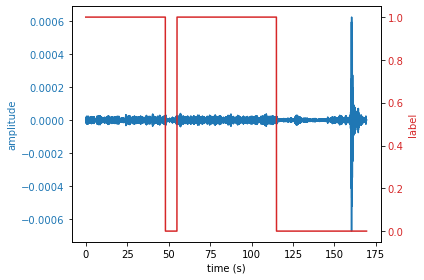

FFT


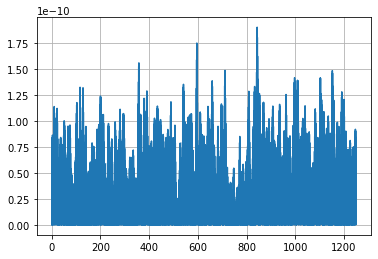

PSD


In [242]:
initLabels.plot_info()

In [243]:
df_dataset = initLabels.generateDataset_time_features()
display(df_dataset)
df_dataset["Label"].value_counts()

CzOz
T7Cz


/home/guyabihanna/anaconda3/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 512 is greater than input length  = 510, using nperseg = 510
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/guyabihanna/anaconda3/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 512 is greater than input length  = 490, using nperseg = 490
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/guyabihanna/anaconda3/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 512 is greater than input length  = 470, using nperseg = 470
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/guyabihanna/anaconda3/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 512 is greater than input length  = 450, using nperseg = 450
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/guyabihanna/anaconda3/lib/python3.8/site-packages/scip

Fp1Fp2
refCz
refT7
refOz
refFp1
sT7sCz


,X1,Y1,stds1,varis1,means1,meds1,maxs1,mins1,rms1,ampli1,...,stds7,varis7,means7,meds7,maxs7,mins7,rms7,ampli7,peakPSD7,avgPSD7
0,0.000,1.304895e-09,4.005613e-06,1.604494e-11,-4.523173e-10,2.914786e-09,2.039111e-05,-0.000020,0.000004,0.000041,...,9.270635e-09,8.594467e-17,1.471372e-08,1.509278e-08,2.857188e-08,-2.805573e-10,1.739075e-08,2.885244e-08,8.379124e-20,1.617702e-20
1,0.008,-1.496884e-06,4.005639e-06,1.604514e-11,-2.492418e-10,3.798468e-09,2.039111e-05,-0.000020,0.000004,0.000041,...,7.423163e-09,5.510334e-17,3.330964e-08,3.513559e-08,4.196702e-08,1.917962e-08,3.412676e-08,2.278740e-08,5.737381e-20,1.016690e-20
2,0.016,-2.349999e-06,4.005651e-06,1.604524e-11,9.103314e-11,4.731320e-09,2.039111e-05,-0.000020,0.000004,0.000041,...,3.883564e-08,1.508207e-15,-1.224565e-07,-1.200771e-07,-6.527531e-08,-1.867685e-07,1.284671e-07,1.214932e-07,1.473151e-18,2.708176e-19
3,0.024,-2.148298e-06,4.005637e-06,1.604513e-11,4.413856e-10,5.739237e-09,2.039111e-05,-0.000020,0.000004,0.000041,...,6.933654e-08,4.807555e-15,-5.044676e-07,-5.028032e-07,-3.984283e-07,-6.154936e-07,5.092103e-07,2.170653e-07,4.661140e-18,8.704297e-19
4,0.032,-8.721413e-07,4.005625e-06,1.604503e-11,6.675258e-10,6.915135e-09,2.039111e-05,-0.000020,0.000004,0.000041,...,8.090566e-08,6.545725e-15,-1.042311e-06,-1.042511e-06,-9.153740e-07,-1.168644e-06,1.045446e-06,2.532701e-07,6.319494e-18,1.195071e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21168,169.344,-9.471629e-06,3.777066e-06,1.426623e-11,-9.399615e-06,-1.084671e-05,5.508816e-09,-0.000013,0.000010,0.000013,...,7.783213e-08,6.057840e-15,1.886684e-06,1.890878e-06,2.002095e-06,1.758693e-06,1.888288e-06,2.434016e-07,5.807844e-18,1.128916e-18
21169,169.352,-1.266239e-05,4.103588e-06,1.683943e-11,-8.873957e-06,-1.025976e-05,5.508816e-09,-0.000013,0.000010,0.000013,...,9.162477e-09,8.395099e-17,2.193489e-06,2.197556e-06,2.201609e-06,2.173329e-06,2.193508e-06,2.828022e-08,9.813768e-20,2.667402e-20
21170,169.360,-1.250847e-05,3.816914e-06,1.456883e-11,-7.270446e-06,-7.822616e-06,5.508816e-09,-0.000013,0.000008,0.000013,...,6.857426e-08,4.702430e-15,1.979935e-06,1.984967e-06,2.079533e-06,1.865250e-06,1.981122e-06,2.142822e-07,4.615148e-18,8.446864e-19
21171,169.368,-8.997875e-06,2.713347e-06,7.362251e-12,-4.720867e-06,-4.845714e-06,5.508816e-09,-0.000009,0.000005,0.000009,...,1.298415e-07,1.685880e-14,1.276159e-06,1.279475e-06,1.474435e-06,1.067941e-06,1.282747e-06,4.064943e-07,1.634778e-17,3.050661e-18


1    13499
0     7674
Name: Label, dtype: int64

In [244]:
# Save the generated dataset (without normalizing)
df_dataset.to_csv("AllChannels_MarRi001_Features_100_512.csv")

In [138]:
# Balance dataset and normalize
df_dataset,signal_df,scaler = initLabels.dataset_balance(df_dataset,normalize=True)
display(df_dataset)
display(signal_df)
print(scaler)
df_dataset["Label"].value_counts()

AttributeError: 'LabelFile' object has no attribute 'dataset_balance'

In [43]:
# Training
classifier = Trainer("RF",df_dataset)

(306902, 6)
(306902,)
Random Forest


In [44]:
classifier.train_test_split(0.3)

Split Done


In [45]:
classifier.fit()

In [46]:
classifier.score(classifier.X_test,classifier.y_test)

0.375058378859793


0.375058378859793

In [21]:
preds = classifier.predict(classifier.X_test)

print(preds)

[0 0 0 ... 0 0 0]


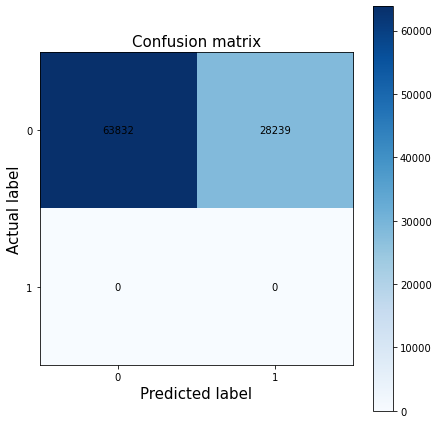

In [22]:
classifier.plot_confusion_matrix(classifier.y_test,preds)

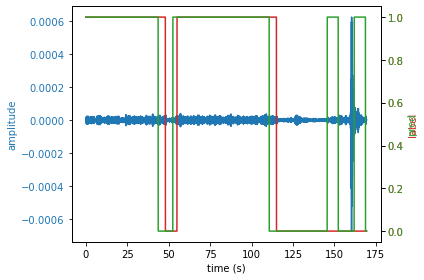

In [23]:
# Plotting training + testing signal (last part of the signal is where it was tested)
classifier.plot_signal_prediction(signal_df,scaler)